<a href="https://colab.research.google.com/github/brianferrell787/Interactive-Word-Embedding-Projector-from-Google-of-your-trained-neural-network/blob/master/WordEmbeddingProjector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**TSNE Projection of Word-Embeddings w/ downloadable word/embedding_index to be used for Google Embedding Projector**

*Remember that you have to train your own algorithim on these word embeddings, since I have already done that I am able to just load my model and get the weights out easily.*

**Install packages and other various tools that could be useful**

In [35]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
## Plot
import matplotlib as plt
# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
# Other
import re
import string
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#Might not be needed
!sudo pip install h5py

**Upload data, clean, preprocessing, etc.**

In [12]:
from numpy.random import seed
seed(42)

In [ ]:
import pandas as pd
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [22]:
#Upload training data used to make the algorithim
train_df = pd.read_excel('Hold Out data.xlsx')
train_df

,ID,AimsGoal,Hypothesis,Background,Study Design,Class
0,HM20013139,Identifying and Prioritizing Patient Goals Bef...,The primary aim of this pilot feasibility stud...,Total Knee Replacement (TKR) surgery is consid...,Design Overview:Pilot feasibility study Sample...,0
1,HM20003563,The Impact of Home Modifications on the Safety...,Participants will report increased performance...,The vast majority of United States homeowners ...,The study will be conducted in collaboration w...,3
2,HM20014813,"Cultural Diversity Within Schools Survey , The...",The research questions guiding this study are:...,The purpose of this survey is to better unders...,Study design: The proposed study will use a su...,3
3,HM20010722,Stakeholder Perspectives on Social Needs Scree...,Research questionsHow do parents of children w...,Approximately 10% of children under age 5 have...,"The overarching, tiered approach to identifica...",0
4,HM20011134,Development of Psychosocial Need Assessment fo...,"The proposed study will develop a reliable, va...",Cystic fibrosis (CF) places children and adole...,"The study will be longitudinal in nature, cons...",0
...,...,...,...,...,...,...
304,HM20002308,Virginia's National Core Indicator Project Sec...,.General research questions will include:ò Wha...,National Core Indicators (NCI) is a collaborat...,This study will be a secondary data analysis o...,1
305,HM15211,Identifying Medication-Related Issues with Tra...,"Dominion Place, located in Richmond, Virginia,...",NaN,Background information on transitions of care ...,3
306,HM20003653,Reporting Intimate Violence to Law Enforcement...,Little is known about when and how African Ame...,The proposed study focuses on developing multi...,To address the dearth of knowledge of African ...,2
307,HM20014642,Barriers to care in the diagnosis and treatmen...,We hypothesize that women who have barriers to...,Despite improved screening programs and vaccin...,"This is a descriptive, observational study inv...",1


In [23]:
#get rid of NULLS 
train_df=train_df.fillna("")
train_df.isnull().any()

In [25]:
#This adds the columns
train_df['Text'] = train_df['AimsGoal'] + train_df['Hypothesis'] + train_df['Background'] + train_df['Study Design'] 
train_df

,ID,AimsGoal,Hypothesis,Background,Study Design,Class,Text
0,HM20013139,Identifying and Prioritizing Patient Goals Bef...,The primary aim of this pilot feasibility stud...,Total Knee Replacement (TKR) surgery is consid...,Design Overview:Pilot feasibility study Sample...,0,Identifying and Prioritizing Patient Goals Bef...
1,HM20003563,The Impact of Home Modifications on the Safety...,Participants will report increased performance...,The vast majority of United States homeowners ...,The study will be conducted in collaboration w...,3,The Impact of Home Modifications on the Safety...
2,HM20014813,"Cultural Diversity Within Schools Survey , The...",The research questions guiding this study are:...,The purpose of this survey is to better unders...,Study design: The proposed study will use a su...,3,"Cultural Diversity Within Schools Survey , The..."
3,HM20010722,Stakeholder Perspectives on Social Needs Scree...,Research questionsHow do parents of children w...,Approximately 10% of children under age 5 have...,"The overarching, tiered approach to identifica...",0,Stakeholder Perspectives on Social Needs Scree...
4,HM20011134,Development of Psychosocial Need Assessment fo...,"The proposed study will develop a reliable, va...",Cystic fibrosis (CF) places children and adole...,"The study will be longitudinal in nature, cons...",0,Development of Psychosocial Need Assessment fo...
...,...,...,...,...,...,...,...
304,HM20002308,Virginia's National Core Indicator Project Sec...,.General research questions will include:ò Wha...,National Core Indicators (NCI) is a collaborat...,This study will be a secondary data analysis o...,1,Virginia's National Core Indicator Project Sec...
305,HM15211,Identifying Medication-Related Issues with Tra...,"Dominion Place, located in Richmond, Virginia,...",,Background information on transitions of care ...,3,Identifying Medication-Related Issues with Tra...
306,HM20003653,Reporting Intimate Violence to Law Enforcement...,Little is known about when and how African Ame...,The proposed study focuses on developing multi...,To address the dearth of knowledge of African ...,2,Reporting Intimate Violence to Law Enforcement...
307,HM20014642,Barriers to care in the diagnosis and treatmen...,We hypothesize that women who have barriers to...,Despite improved screening programs and vaccin...,"This is a descriptive, observational study inv...",1,Barriers to care in the diagnosis and treatmen...


In [26]:
#Not needed but seeing how our data is 
unique = train_df.groupby('Class').nunique()
print (unique)

        ID  AimsGoal  Hypothesis  Background  Study Design  Class  Text
Class                                                                  
0       89        89          87          88            84      1    89
1       46        46          46          45            46      1    46
2       16        16          16          16            16      1    16
3      108       108         108         105           106      1   108
4       35        35          34          34            34      1    35
5       15        15          15          15            15      1    15


In [27]:
import nltk
import re  
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [28]:
#defining our cleaning function 
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    nltk.download('stopwords')
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", "  ", text)
    text = re.sub(r"=", "  ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", "  ", text)
    text = re.sub(r";", "  ", text)
    text = re.sub(r"http", "  ", text)
    text = re.sub(r"www", "  ", text)
    text = re.sub(r"-", "  ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"\d+", " ", text)

    ## Lemmatize
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(lemma_words)

    return text


In [29]:
# apply the above function to df['text']
traintext = train_df['Text'].map(lambda x: clean_text(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /ro

In [30]:
#cleaned up output of data 
traintext

0      identifying prioritizing patient goal total kn...
1      impact home modification safety community dwel...
2      cultural diversity within school survey resear...
3      stakeholder perspective social need screening ...
4      development psychosocial need assessment cysti...
                             ...                        
304    virginia national core indicator project secon...
305    identifying medication related issue transitio...
306    reporting intimate violence law enforcement af...
307    barrier care diagnosis treatment cervical dysp...
308    accountable health community accountable healt...
Name: Text, Length: 309, dtype: object

In [31]:
print(max(traintext))

youth outcome evaluation person assisting research completed passed citi training course trained team member descriptive instruction data collection analysis procedure team meet weekly review research plan maintain regular communication teleconference meeting email primary method communication time formal meeting information learn student study may help design better program youth community school ray glenwood njo burlington somerset township nj postal mail in person communication the three public school system bloom high school il franklin high school nj burlington high school nj mail pre formed information letter parent guardian permission research child parent student contact address information letter parent guardian permission research child research team meet student th grade english class time research team explain voluntary study obtain assent consent mama foundation art new york ny in person electronic communication for mama foundation foundation email pre formed information l

In [32]:
#this sentence was taken from the actual training set, so the maxlen needed to be this length anyways and not the maxlen of the hold out data set I uploaded. This is just to show how things work
max = "youth research evaluation person assisting research completed passed citi training program trained team member descriptive procedure data collection analysis procedure team meet weekly review research plan maintain regular meeting teleconference meeting email primary form communication time formal study lesson learn student program may help design better program youth community school glenwood njo somerset county electronic mail person communication three elementary school system bloom high school hudson high school burlington middle school email pre formed information letter parent guardian permission research child parent student address information letter parent guardian permission research child research team meet student th grade freshman class time research team explain voluntary study obtain assent consent mama foundation art north york person electronic communication mama foundation foundation email pre prepared information letter parent guardian permission research child parent past participant auditioned enroll mama foundation program student research team meet student regular scheduled rehearsal time research team explain voluntary study request assent permission mama foundation non program student research team email link online survey electronic consent assent given administration question concern involvement research answered guardian team year amended year follow aal program participant individual provided contact information agreed permission contact month high school graduation researcher team reach individual requesting contact email phone number elected provide second year study first team meet participant via email reminding second year study second team member contact participant see willing participate phone interview point also asked complete online survey emailed following day primary goal project better understand role nonprofit organization involvement youth community research questionso youth participant medium short term life outcome outcome inform discourse issue facing risk youth best strategy enhancing life outcome youth differentiate participate nonprofit organization year amended youth participant medium short term living outcome outcome influence discourse challenge facing risk youth adult youth best strategy improving life outcome youth there intervention involved study observer adult disability parent person disability professional serving people disability nang china observer recruited local ngo serving people disability researcher worked participant ngo meantime healthy productive relationship individual informed study technical advisor learning study individual participated participation asked set specific appointment location likely location participant home local coffee shop typical neighborhood meeting place community office ngo least one member interview team meet participant location invitation informed consent process completed start meeting consent provided semi structured interview begin interview guided basic oral interview protocol english french speaker attached participant grant permission interview electronically recorded interview likely take minute end interview participant receive dong offset additional cost appreciation time commitment overweight obesity major public health problem united state according national health nutrition examination survey nhanes one every three woman united kingdom obese nhanes data reveals prevalence high body mass index overweight obesity middle age woman highest among black woman hispanic woman female diabetes obesity pregnancy particular concern due adverse consequence mother offspring particularly black hispanic woman established adverse consequence mother include gestational diabetes mellitus type diabetes pregnancy induced hypertensive disorder caesarean delivery preterm delivery maternal mortality present future obesity metabolism disorder maternal obesity also serious consequence offspring increased incidence delivery complication congenital anomaly respiratory disorder neonatal disorder obesity metabolism disorder later life institute medicine iom published guideline recommended level weight gain pregnancy suggested research critically needed assist minority woman intervention control weight loss teenage pregnancy crucial time weight management intervention weight retention weight gain time important predictor long term health numerous study evaluated validated positive impact prenatal care reducing adverse health outcome pregnant woman offspring however maternal prenatal intervention spc currently seem impact healthy lifestyle behavior explicitly manage adverse health concern obesity stress anxiety rumination may contribute sedentary lifestyle result widespread movement improve traditional model prenatal care order achieve healthy people goal increasing prenatal care utilization address pronounced racial ethnic disparity pregnancy outcome health centering pregnancy care cpc group prenatal intervention model designed address individual lifestyle health problem affecting pregnant woman woman prenatal period cpc guideline incorporates several component prenatal care individual risk factor targeted education group support woman encouraged take responsibility equipping skill increase self efficacy self motivation engage healthy behavior several study conducted evaluate impact cpc maternal infant health feasibility receptiveness among pregnant woman particularly higher risk experiencing adverse pregnancy outcome earlier study demonstrated woman group care higher appreciation satisfaction le inadequate prenatal care woman traditional care group woman participating group care also significantly better knowledge related pregnancy general health woman received traditional prenatal care number study including randomized controlled intervention found cpc recipient significantly lower incidence preterm birth low birth weight infant comparison group despite extensive curriculum healthy diet none study examined effect cpc model excessive weight gain pregnancy management mental health depression stress anxiety rumination impact woman infant study hypothesized group care may lead reduced stress improved mood improved healthy lifestyle choice partly due effect support group phenomenon chronic stress related health disparity low grade inflammation associated obesity may play key role pathogenesis multiple condition impact maternal child health including gestational diabetes depression high blood pressure preterm birth child risk future obesity related disease particular innovative non invasive method assessing stress salivary nerve growth factor ngf ngf neurotrophin involved development maintenance neuron central peripheral nervous system recent study suggest ngf level change response psychosocial stress particular interest proposed study preliminary evidence suggests minority low income status pregnancy associated dysregulated maternal stress response system preliminary study short term meditative mindful intervention suggest benefit intervention may stem epigenetic pathway involved inflammatory process neurobiological stress response specifically one study evaluated effect yoga salivary ngf increased expression yogic breathing physical practice thus study explore role salivary ngf non invasive stress measure outcome yoga chosen mode combined cpc several reason first gentle introduction mindfulness may helpful preventing weight gain enhancing self efficacy healthy lifestyle second one pi used yoga intervention depression symptom management mood strong influence choice regarding physical activity third pregnant woman expressed interest yoga self management weight mood yoga may also contribute positive experience may turn contribute self efficacy enhance motivation future study shown practicing yoga pregnancy reduces anxiety depressive symptom sedentary lifestyle low level may impact marker inflammation evidence even suggests yoga positive effect perceived stress level social support group however study showing yoga effective weight control mechanism pregnant woman especially obese scarce yoga may help overweight obese woman manage weight giving opportunity physically active experience increased confidence competence self efficacy furthermore engagement yoga may decrease depressive symptom related stress anxiety rumination known barrier weight management effort yoga ideal study within population interest safe pregnancy done woman overweight obese done strenuous prior pregnancy physical activity pregnancy evaluated study within context preventing adverse birth outcome preterm birth low birth weight study proposes cpc model inclusion yoga practice cpc warrant attention potential benefit regard weight management maternal mental wellness long term outcome theoretical foundation group prenatal care model plus yoga tested study cpc grounded social cognitive theory sct sct widely used health behavior intervention sct state behavior change affected environmental influence individual factor attribute behavior factor may influence compounded effect health individual central target intervention sct concept self efficacy pregnant woman must believe capability perform behavior must understand outcome consequence belief occur result performing specific behavior preventing excessive weight gain pregnancy engaging healthy outcome may classified immediate benefit achieving desired weight gain improving mental wellness decreased depression symptom rumination stress anxiety long term benefit delivering healthy baby preventing offspring obesity reaching normal weight postpartum reducing risk diabetes pregnancy induced hypertension self efficacy believed single important characteristic determines person behavior change self efficacy self motivation expected improved cpc especially among diverse pregnant woman providing intervention targeting individual need social support addressing environmental influence setting goal providing clear instruction enabling gentle controlled environment encouraging desired behavior expect cpc environmental influence maternal factor attribute behavior addressed"

In [33]:
len(max)

10137

In [63]:
### Create Tokens, Sequences, and Paddings
vocabulary_size = 19000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(traintext)
sequences = tokenizer.texts_to_sequences(traintext)
xtrain = pad_sequences(sequences, maxlen=10137)

In [64]:
len(xtrain)

309

**Download GloVe Embeddings and use TSNE to visualize those word embeddings** 

In [ ]:
# download pretrained GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-08-09 11:51:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-09 11:51:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-09 11:51:30--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip -q glove.6B.zip

In [38]:
import os
import numpy as np  

In [67]:
glove_dir = './'

embeddings_index = {} #initialize dictionary
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [65]:
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [66]:
len(embedding_matrix)

19000

 **Import Keras components and other tools**

In [46]:
#Because my model has a custom attention layer I have to re-create it 
from keras.engine.topology import Layer
from keras.layers import Layer
import keras.backend as K
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [48]:
#Loading my already trained model. REMEMBER IF YOU DIDN'T TRAIN A MODEL YOU NEED TO DO THAT FOR THIS TO WORK
from keras.models import load_model
from keras.utils.generic_utils import CustomObjectScope
model = load_model('whole69.mdl_wts.hdf5',custom_objects={'attention': attention},compile=True)

In [49]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 10137)]      0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 10137, 100)   1900000     input_9[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_9 (SpatialDro (None, 10137, 100)   0           embedding_9[0][0]                
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 10137, 128)   84992       spatial_dropout1d_9[0][0]        
____________________________________________________________________________________________

## **Word Embedding Projector(captures weights, dimensions, and word list for labels)**
Google "Word Embedding Projector" to upload everything

In [68]:
#retrieve list of words in training set 
word_list = []
for word, i in tokenizer.word_index.items():
    word_list.append(word)

In [69]:
len(word_list) 


19575

In [70]:
word_list[:1000]

['study',
 'participant',
 'research',
 'data',
 'community',
 'health',
 'student',
 'intervention',
 'program',
 'group',
 'patient',
 'school',
 'survey',
 'care',
 'child',
 'use',
 'information',
 'based',
 'individual',
 'al',
 'also',
 'family',
 'time',
 'service',
 'project',
 'training',
 'question',
 'need',
 'self',
 'may',
 'outcome',
 'used',
 'risk',
 'year',
 'social',
 'interview',
 'using',
 'one',
 'measure',
 'focus',
 'behavior',
 'team',
 'assessment',
 'practice',
 'support',
 'teacher',
 'staff',
 'vcu',
 'member',
 'session',
 'provide',
 'well',
 'level',
 'treatment',
 'analysis',
 'consent',
 'parent',
 'adult',
 'virginia',
 'youth',
 'experience',
 'education',
 'form',
 'population',
 'two',
 'related',
 'meeting',
 'include',
 'contact',
 'factor',
 'complete',
 'cancer',
 'screening',
 'number',
 'potential',
 'woman',
 'work',
 'within',
 'development',
 'among',
 'aim',
 'a',
 'activity',
 'participate',
 'recruitment',
 'scale',
 'goal',
 'eg',
 'car

In [73]:
#making sure I get the right layer 
model.layers[1]

In [74]:
## Get weights
glove_embds = model.layers[1].get_weights()[0]


In [89]:
print(glove_embds.shape)

(19000, 100)


In [76]:
## Visualize words in two dimensions 
glove_tsne_embds = TSNE(n_components=2).fit_transform(glove_embds)


In [77]:
glove_embds 

array([[ 0.0176866 ,  0.0177915 ,  0.00943494, ...,  0.0019271 ,
        -0.01265795, -0.04369885],
       [ 0.1777509 ,  0.7636216 , -0.2541459 , ..., -0.9848846 ,
         0.16405587, -0.18264109],
       [-0.14604557,  0.46648785, -0.11059082, ..., -0.06615601,
        -0.01416065,  0.18884987],
       ...,
       [-0.16091906,  0.13610096, -0.10157314, ...,  0.415101  ,
         0.01723853, -0.5437566 ],
       [-0.5943805 ,  0.5652125 ,  0.0224079 , ...,  0.27449372,
        -1.0949826 ,  0.17128351],
       [-0.35074916,  0.35477257,  0.0043706 , ..., -0.26522094,
         1.1002392 , -0.07594203]], dtype=float32)

In [80]:
import matplotlib.pyplot as plt
def plot_words(data, start, stop, step):
  x = data[start:stop:step,0]
  y = data[start:stop:step, 1]
  colors = (1,0,1)
  area = np.pi*3
  plt.scatter(x, y, s=area, c=colors, alpha=0.5)
  plt.title('Scatter plot of Embeddings')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


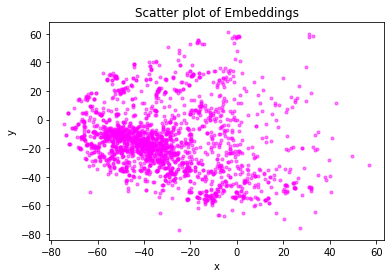

In [81]:
#plot TSNE
plot_words(glove_tsne_embds, 0, 2000, 1) 

In [82]:
embedding_matrix[:12000]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.10404   ,  0.76422   , -0.44189   , ..., -0.92447001,
         0.3229    , -0.042366  ],
       [-0.11616   ,  0.43687001, -0.073795  , ...,  0.089843  ,
        -0.019763  ,  0.31132001],
       ...,
       [ 0.40726   ,  0.15717   , -0.35510001, ...,  0.12654001,
         0.32587999,  0.5625    ],
       [-0.085692  , -0.57353997,  0.43934   , ..., -1.01180005,
        -1.13479996,  0.53457999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

These next codes create the files in the format for the embedding projector. FYI the Google platform really works well with just 10,000 words, so you might notice anything after word number 10,000 the dots will all be in the same

In [83]:
import io

out_v = io.open('embeddings.tsv', 'w', encoding='utf-8')

for num in embedding_matrix:
 
  out_v.write('\t'.join([str(x) for x in num]) + "\n")
out_v.close()


In [87]:
#I take the first 19000 because that was the max vocab size even though there are about 19500 words to be exact
import io

out_m = io.open('metadata.tsv', 'w', encoding='utf-8')


for word in word_list[:19000]:
 
  
  out_m.write(word + "\n")
  

out_m.close()



In [88]:
#These codes will download your word list(metadata), and embedding matrix as tsv files. You then go to https://projector.tensorflow.org/ and upload them
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('metadata.tsv')
  files.download('embeddings.tsv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>